# Dataset

In [1]:
# Very few imports. This is a pure torch solution!
# import cv2
import time

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import torch
from torch.utils.data import DataLoader
import torchvision
# from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection import FasterRCNN

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BASE_DIR = "tensorflow-great-barrier-reef/train_images/"

NUM_EPOCHS = 12

In [2]:
df = pd.read_csv("tensorflow-great-barrier-reef/train.csv")
df['is_train'] = (df.index >= 20000)
# Turn annotations from strings into lists of dictionaries
df['annotations'] = df['annotations'].apply(eval)

# Create the image path for the row
df['image_path'] = "video_" + df['video_id'].astype(str) + "/" + df['video_frame'].astype(str) + ".jpg"

df.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,is_train,image_path
0,0,40258,0,0,0-0,[],False,video_0/0.jpg
1,0,40258,1,1,0-1,[],False,video_0/1.jpg
2,0,40258,2,2,0-2,[],False,video_0/2.jpg
3,0,40258,3,3,0-3,[],False,video_0/3.jpg
4,0,40258,4,4,0-4,[],False,video_0/4.jpg


In [3]:
df_train, df_val = df[df['is_train']], df[~df['is_train']]
df_train = df_train[df_train.annotations.str.len() > 0 ].reset_index(drop=True)
df_val = df_val[df_val.annotations.str.len() > 0 ].reset_index(drop=True)

In [4]:
df_train.shape[0], df_val.shape[0]

(210, 4709)

# Dataset class

In [5]:
class ReefDataset:

    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def can_augment(self, boxes):
        """ Check if bounding boxes are OK to augment
        
        
        For example: image_id 1-490 has a bounding box that is partially outside of the image
        It breaks albumentation
        Here we check the margins are within the image to make sure the augmentation can be applied
        """
        
        box_outside_image = ((boxes[:, 0] < 0).any() or (boxes[:, 1] < 0).any() 
                             or (boxes[:, 2] > 1280).any() or (boxes[:, 3] > 720).any())
        return not box_outside_image

    def get_boxes(self, row):
        """Returns the bboxes for a given row as a 3D matrix with format [x_min, y_min, x_max, y_max]"""
        
        boxes = pd.DataFrame(row['annotations'], columns=['x', 'y', 'width', 'height']).astype(float).values
        
        # Change from [x_min, y_min, w, h] to [x_min, y_min, x_max, y_max]
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return boxes
    
    def get_image(self, row):
        """Gets the image for a given row"""
        
        image = cv2.imread(f'{BASE_DIR}/{row["image_path"]}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        return image
    
    def __getitem__(self, i):

        row = self.df.iloc[i]
        image = self.get_image(row)
        boxes = self.get_boxes(row)
        
        n_boxes = boxes.shape[0]
        
        # Calculate the area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        
        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'area': torch.as_tensor(area, dtype=torch.float32),
            
            'image_id': torch.tensor([i]),
            
            # There is only one class
            'labels': torch.ones((n_boxes,), dtype=torch.int64),
            
            # Suppose all instances are not crowd
            'iscrowd': torch.zeros((n_boxes,), dtype=torch.int64)            
        }

        if self.transforms and self.can_augment(boxes):
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            if n_boxes > 0:
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        else:
            image = ToTensorV2(p=1.0)(image=image)['image']

        return image, target

    def __len__(self):
        return len(self.df)

## Augmentations

In [6]:
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [7]:
# Define datasets
ds_train = ReefDataset(df_train, get_train_transform())
ds_val = ReefDataset(df_val, get_valid_transform())

## Check one sample

In [8]:
df_val[df_val.annotations.str.len() > 12].head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,is_train,image_path
2552,1,8503,4173,345,1-4173,"[{'x': 428, 'y': 156, 'width': 36, 'height': 2...",False,video_1/4173.jpg
2553,1,8503,4174,346,1-4174,"[{'x': 421, 'y': 156, 'width': 36, 'height': 2...",False,video_1/4174.jpg
2554,1,8503,4175,347,1-4175,"[{'x': 415, 'y': 157, 'width': 36, 'height': 2...",False,video_1/4175.jpg
2555,1,8503,4176,348,1-4176,"[{'x': 409, 'y': 157, 'width': 36, 'height': 2...",False,video_1/4176.jpg
2556,1,8503,4177,349,1-4177,"[{'x': 403, 'y': 157, 'width': 36, 'height': 2...",False,video_1/4177.jpg


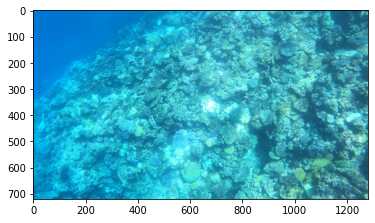

In [9]:
image = plt.imread(os.path.join('tensorflow-great-barrier-reef\\train_images', df_val.iloc[2552]['image_path']))
plt.imshow(image)

In [10]:
targets = df_val.iloc[2552]['annotations']
targets = np.array([[elem[k] for k in elem.keys()] for elem in targets])
targets

array([[428, 156,  36,  26],
       [359, 539,  25,  25],
       [623, 228,  39,  44],
       [682, 317,  41,  40],
       [273, 217,  30,  25],
       [420, 172,  36,  36],
       [737, 376,  63,  67],
       [243, 293,  56,  40],
       [777, 349,  39,  59],
       [326, 256,  24,  24],
       [140, 409,  30,  37],
       [170, 450,  29,  34],
       [642, 547,  32,  36]])

In [11]:
# boxes = torch.Tensor(targets).cpu().numpy().astype(np.int32)
# img = torch.Tensor(image).permute(1,2,0).cpu().numpy()
# fig, ax = plt.subplots(1, 1, figsize=(16, 8))

# for box in boxes:
#     cv2.rectangle(img,
#                   (box[0], box[1]),
#                   (box[2], box[3]),
#                   (220, 0, 0), 3)
    
# ax.set_axis_off()
# ax.imshow(img);

## DataLoaders

In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))

dl_train = DataLoader(ds_train, batch_size=2, shuffle=False, num_workers=0, collate_fn=collate_fn)
dl_val = DataLoader(ds_val, batch_size=2, shuffle=False, num_workers=0, collate_fn=collate_fn)

# Create the model

In [13]:
def get_model():
    # load a model; pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    num_classes = 2  # 1 class (starfish) + background

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    model.to(DEVICE)
    return model

model = get_model()

# Train

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0025, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

n_batches, n_batches_val = len(dl_train), len(dl_val)
validation_losses = []


for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    loss_accum = 0
    
    for batch_idx, (images, targets) in enumerate(dl_train, 1):
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        # Predict
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_accum += loss_value

        # Back-prop
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    # Validation 
    val_loss_accum = 0
        
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(dl_val, 1):
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            
            val_loss_dict = model(images, targets)
            val_batch_loss = sum(loss for loss in val_loss_dict.values())
            val_loss_accum += val_batch_loss.item()
    
    # Logging
    val_loss = val_loss_accum / n_batches_val
    train_loss = loss_accum / n_batches
    validation_losses.append(val_loss)
    
    # Save model
    chk_name = f'fasterrcnn_resnet50_fpn-e{epoch}.bin'
    torch.save(model.state_dict(), chk_name)
    
    
    elapsed = time.time() - time_start
    
    print(f"[Epoch {epoch+1:2d} / {NUM_EPOCHS:2d}] Train loss: {train_loss:.3f}. Val loss: {val_loss:.3f} --> {chk_name}  [{elapsed:.0f} secs]")   

C:\ProgramData\Anaconda3\envs\dl\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[Epoch  1 / 12] Train loss: 0.180. Val loss: 0.231 --> fasterrcnn_resnet50_fpn-e0.bin  [1149 secs]
[Epoch  2 / 12] Train loss: 0.161. Val loss: 0.248 --> fasterrcnn_resnet50_fpn-e1.bin  [1108 secs]
[Epoch  3 / 12] Train loss: 0.152. Val loss: 0.256 --> fasterrcnn_resnet50_fpn-e2.bin  [998 secs]
[Epoch  4 / 12] Train loss: 0.121. Val loss: 0.281 --> fasterrcnn_resnet50_fpn-e3.bin  [1125 secs]


In [ ]:
validation_losses

In [ ]:
np.argmin(validation_losses)

# Result

In [ ]:
idx = 0

images, targets = next(iter(dl_val))
images = list(img.to(DEVICE) for img in images)
targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

boxes = targets[idx]['boxes'].cpu().numpy().astype(np.int32)
sample = images[idx].permute(1,2,0).cpu().numpy()

model.eval()

outputs = model(images)
outputs = [{k: v.detach().cpu().numpy() for k, v in t.items()} for t in outputs]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

# Red for ground truth
for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)

    
# Green for predictions
# Print the first 5
for box in outputs[idx]['boxes'][:5]:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (0, 220, 0), 3)

ax.set_axis_off()
ax.imshow(sample);

In [ ]:
torch.save(model, 'model.h5')